In [1]:
import sys

import xarray as xr
import matplotlib.pyplot as plt
import xgcm
import gcm_filters
import argparse
from dask.diagnostics import ProgressBar
import os
import sys
import numpy as np

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# 20-days versus 20-years y100 in initial ensemble

In [ ]:
y100 = xr.open_dataset('/scratch/pp2681/mom6/CM26_Double_Gyre/calibration/hundred-years/R2_FGR3_series/y100.nc').isel(iter=0).isel(res=0)

In [3]:
data = xr.open_mfdataset('/scratch/pp2681/mom6/Feb2022/filtered/R32_R2_FGR3/high_frequency/*.nc', decode_times=False, combine='nested', concat_dim='Time').astype('float64').fillna(0.).sortby('Time')
data['Time'] = data['Time'] -  data['Time'].isel(Time=0)

In [4]:
ssh_ens = xr.DataArray(np.zeros((100, 360, 2, 40, 44)) * np.nan, dims=['ens', 'Time', 'zi', 'yh', 'xh'])
ssh_true = data.e.isel(Time=slice(1,361)).isel(zi=slice(0,2))
for ens_member in range(100):
    try:
        ssh_ens[ens_member] = xr.open_dataset(f'/scratch/pp2681/mom6/CM26_Double_Gyre/calibration/online_training/R2_FGR3_test_360/iteration-00/R2/ens-member-{ens_member:02d}/output/prog__0001_002.nc').e.isel(zi=slice(0,2))
    except:
        pass

In [55]:
def RMSE_snapshot(day_max=20, zi=0, coarsen=1):
    return np.sqrt(((ssh_ens.isel(Time=slice(0,day_max)) - ssh_true.isel(Time=slice(0,day_max))).coarsen({'xh':coarsen, 'yh':coarsen}).mean()**2).mean(['xh', 'yh', 'Time'])).isel(zi=zi)

In [6]:
def RMSE_mean(day_max=20, zi=0):
    return np.sqrt(((ssh_ens.isel(Time=slice(0,day_max)).mean('Time') - ssh_true.isel(Time=slice(0,day_max)).mean('Time'))**2).mean(['xh', 'yh'])).isel(zi=zi)

In [63]:
def RMSE_snapshot_var_scaled(day_max=20, zi=0):
    var_scaling = ssh_ens.var('ens').mean(['xh', 'yh'])
    return np.sqrt(((ssh_ens.isel(Time=slice(0,day_max)) - ssh_true.isel(Time=slice(0,day_max)))**2 / var_scaling.isel(Time=slice(0,day_max))).mean(['xh', 'yh', 'Time'])).isel(zi=zi)

In [9]:
lags = xr.DataArray([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], dims='lag')
rmse_snapshot_lags = xr.concat([RMSE_snapshot(j.item()) for j in lags], dim='lag').compute()
rmse_snapshot_lags['lag'] = lags

In [56]:
rmse_coarsen_snapshot_lags = xr.concat([RMSE_snapshot(j.item(), coarsen=4) for j in lags], dim='lag').compute()
rmse_coarsen_snapshot_lags['lag'] = lags

In [64]:
rmse_var_snapshot_lags = xr.concat([RMSE_snapshot_var_scaled(j.item()) for j in lags], dim='lag').compute()
rmse_var_snapshot_lags['lag'] = lags

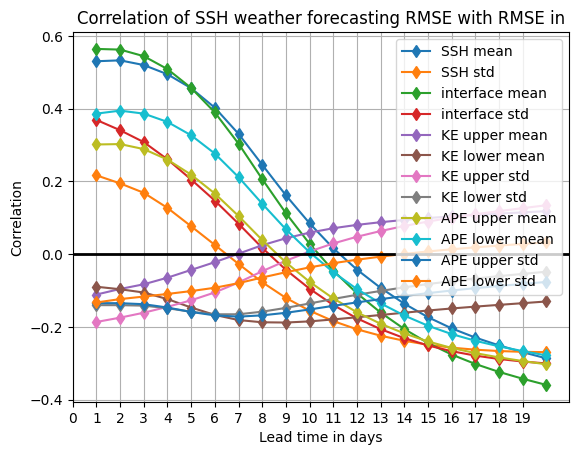

In [42]:
xr.corr(rmse_snapshot_lags, y100.RMSE_e_mean.isel(zi=0), 'ens').plot(label='SSH mean', marker='d')
xr.corr(rmse_snapshot_lags, y100.RMSE_e_std.isel(zi=0), 'ens').plot(label='SSH std', marker='d')
xr.corr(rmse_snapshot_lags, y100.RMSE_e_mean.isel(zi=1), 'ens').plot(label='interface mean', marker='d')
xr.corr(rmse_snapshot_lags, y100.RMSE_e_std.isel(zi=1), 'ens').plot(label='interface std', marker='d')
xr.corr(rmse_snapshot_lags, y100.RMSE_KE_mean.isel(zl=0), 'ens').plot(label='KE upper mean', marker='d')
xr.corr(rmse_snapshot_lags, y100.RMSE_KE_mean.isel(zl=1), 'ens').plot(label='KE lower mean', marker='d')
xr.corr(rmse_snapshot_lags, y100.RMSE_KE_std.isel(zl=0), 'ens').plot(label='KE upper std', marker='d')
xr.corr(rmse_snapshot_lags, y100.RMSE_KE_std.isel(zl=1), 'ens').plot(label='KE lower std', marker='d')
xr.corr(rmse_snapshot_lags, y100.RMSE_APE_mean.isel(zi=0), 'ens').plot(label='APE upper mean', marker='d')
xr.corr(rmse_snapshot_lags, y100.RMSE_APE_mean.isel(zi=1), 'ens').plot(label='APE lower mean', marker='d')
xr.corr(rmse_snapshot_lags, y100.RMSE_APE_std.isel(zi=0), 'ens').plot(label='APE upper std', marker='d')
xr.corr(rmse_snapshot_lags, y100.RMSE_APE_std.isel(zi=1), 'ens').plot(label='APE lower std', marker='d')
plt.xlabel('Lead time in days')
plt.ylabel('Correlation')
plt.title('Correlation of SSH weather forecasting RMSE with RMSE in')
plt.legend()
plt.xticks(np.arange(20));
plt.grid()
plt.axhline(y=0, color='k', lw=2)

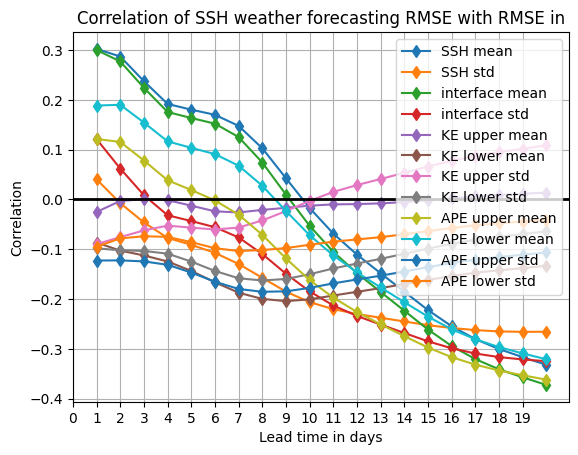

In [62]:
# Coarsening does not help much to utilize larger lag times
xr.corr(rmse_coarsen_snapshot_lags, y100.RMSE_e_mean.isel(zi=0), 'ens').plot(label='SSH mean', marker='d')
xr.corr(rmse_coarsen_snapshot_lags, y100.RMSE_e_std.isel(zi=0), 'ens').plot(label='SSH std', marker='d')
xr.corr(rmse_coarsen_snapshot_lags, y100.RMSE_e_mean.isel(zi=1), 'ens').plot(label='interface mean', marker='d')
xr.corr(rmse_coarsen_snapshot_lags, y100.RMSE_e_std.isel(zi=1), 'ens').plot(label='interface std', marker='d')
xr.corr(rmse_coarsen_snapshot_lags, y100.RMSE_KE_mean.isel(zl=0), 'ens').plot(label='KE upper mean', marker='d')
xr.corr(rmse_coarsen_snapshot_lags, y100.RMSE_KE_mean.isel(zl=1), 'ens').plot(label='KE lower mean', marker='d')
xr.corr(rmse_coarsen_snapshot_lags, y100.RMSE_KE_std.isel(zl=0), 'ens').plot(label='KE upper std', marker='d')
xr.corr(rmse_coarsen_snapshot_lags, y100.RMSE_KE_std.isel(zl=1), 'ens').plot(label='KE lower std', marker='d')
xr.corr(rmse_coarsen_snapshot_lags, y100.RMSE_APE_mean.isel(zi=0), 'ens').plot(label='APE upper mean', marker='d')
xr.corr(rmse_coarsen_snapshot_lags, y100.RMSE_APE_mean.isel(zi=1), 'ens').plot(label='APE lower mean', marker='d')
xr.corr(rmse_coarsen_snapshot_lags, y100.RMSE_APE_std.isel(zi=0), 'ens').plot(label='APE upper std', marker='d')
xr.corr(rmse_coarsen_snapshot_lags, y100.RMSE_APE_std.isel(zi=1), 'ens').plot(label='APE lower std', marker='d')
plt.xlabel('Lead time in days')
plt.ylabel('Correlation')
plt.title('Correlation of SSH weather forecasting RMSE with RMSE in')
plt.legend()
plt.xticks(np.arange(20));
plt.grid()
plt.axhline(y=0, color='k', lw=2)

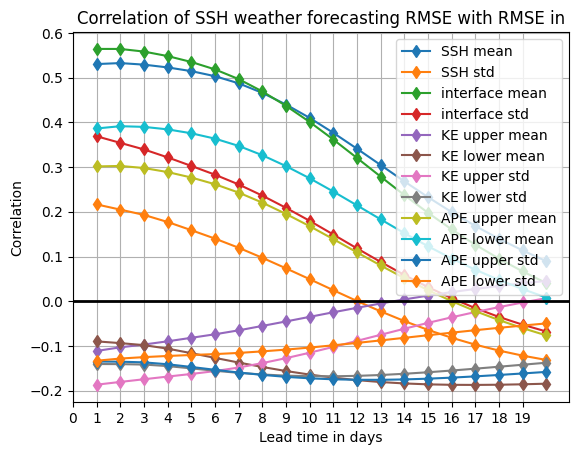

In [65]:
# Coarsening does not help much to utilize larger lag times
xr.corr(rmse_var_snapshot_lags, y100.RMSE_e_mean.isel(zi=0), 'ens').plot(label='SSH mean', marker='d')
xr.corr(rmse_var_snapshot_lags, y100.RMSE_e_std.isel(zi=0), 'ens').plot(label='SSH std', marker='d')
xr.corr(rmse_var_snapshot_lags, y100.RMSE_e_mean.isel(zi=1), 'ens').plot(label='interface mean', marker='d')
xr.corr(rmse_var_snapshot_lags, y100.RMSE_e_std.isel(zi=1), 'ens').plot(label='interface std', marker='d')
xr.corr(rmse_var_snapshot_lags, y100.RMSE_KE_mean.isel(zl=0), 'ens').plot(label='KE upper mean', marker='d')
xr.corr(rmse_var_snapshot_lags, y100.RMSE_KE_mean.isel(zl=1), 'ens').plot(label='KE lower mean', marker='d')
xr.corr(rmse_var_snapshot_lags, y100.RMSE_KE_std.isel(zl=0), 'ens').plot(label='KE upper std', marker='d')
xr.corr(rmse_var_snapshot_lags, y100.RMSE_KE_std.isel(zl=1), 'ens').plot(label='KE lower std', marker='d')
xr.corr(rmse_var_snapshot_lags, y100.RMSE_APE_mean.isel(zi=0), 'ens').plot(label='APE upper mean', marker='d')
xr.corr(rmse_var_snapshot_lags, y100.RMSE_APE_mean.isel(zi=1), 'ens').plot(label='APE lower mean', marker='d')
xr.corr(rmse_var_snapshot_lags, y100.RMSE_APE_std.isel(zi=0), 'ens').plot(label='APE upper std', marker='d')
xr.corr(rmse_var_snapshot_lags, y100.RMSE_APE_std.isel(zi=1), 'ens').plot(label='APE lower std', marker='d')
plt.xlabel('Lead time in days')
plt.ylabel('Correlation')
plt.title('Correlation of SSH weather forecasting RMSE with RMSE in')
plt.legend()
plt.xticks(np.arange(20));
plt.grid()
plt.axhline(y=0, color='k', lw=2)

In [60]:
RMSE_ssh_mean = y100.RMSE_e_mean.isel(zi=0)
RMSE_ssh_std = y100.RMSE_e_std.isel(zi=0)

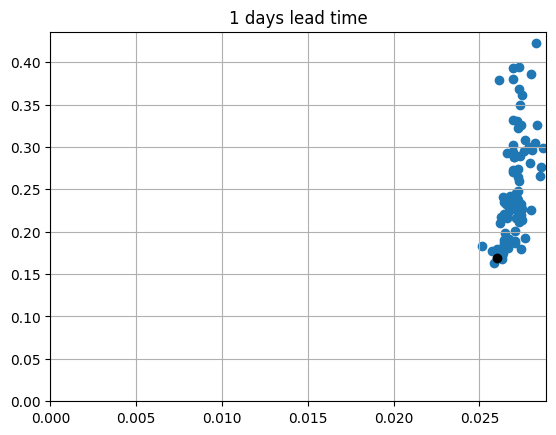

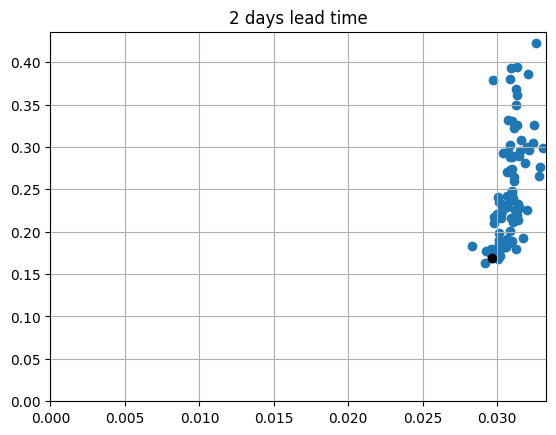

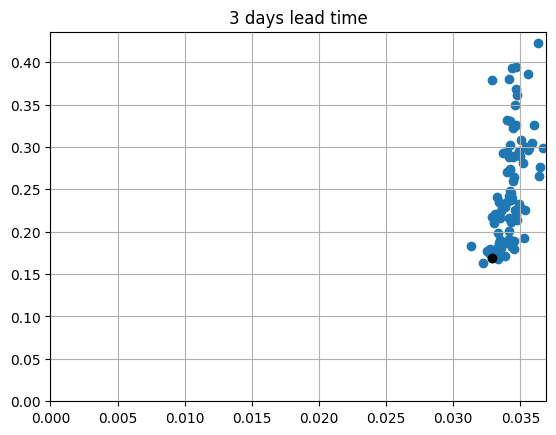

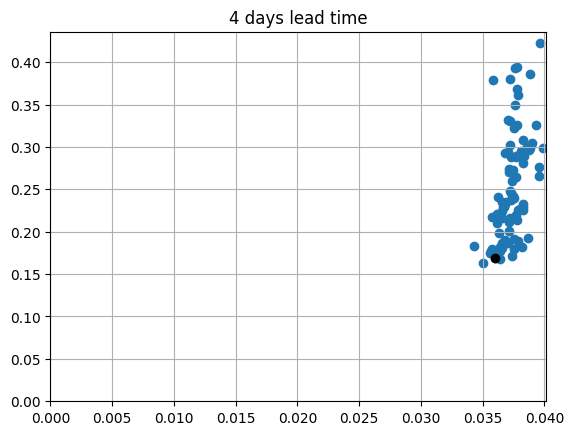

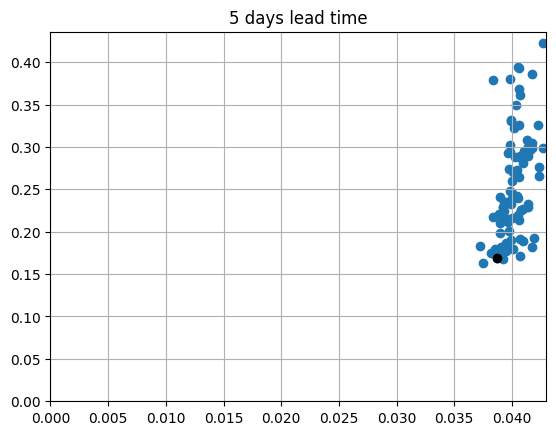

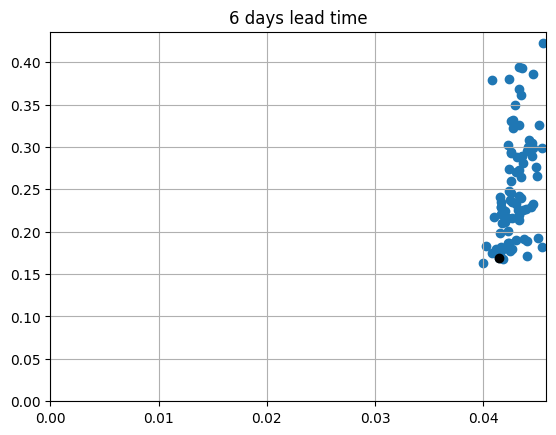

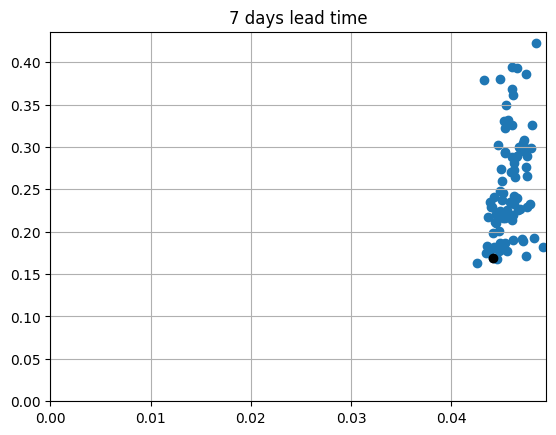

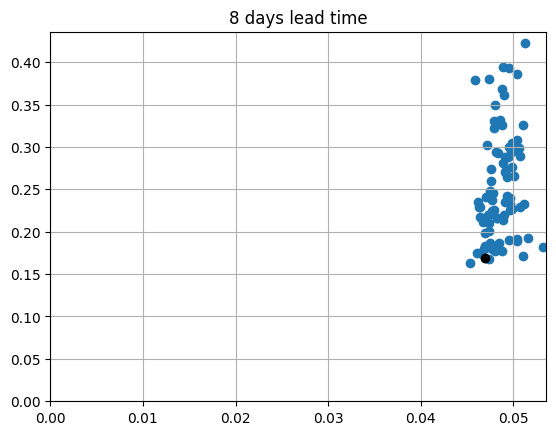

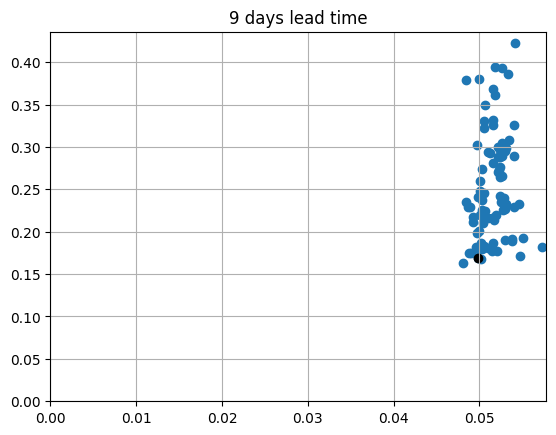

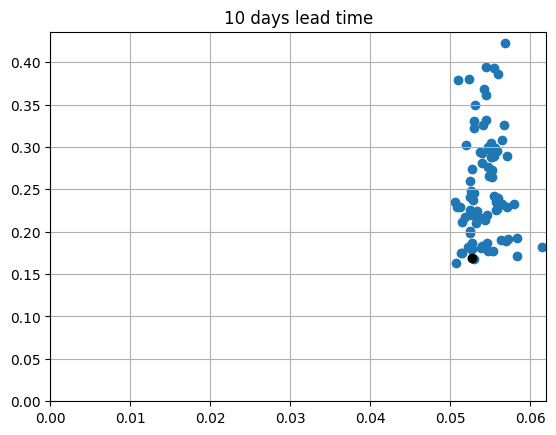

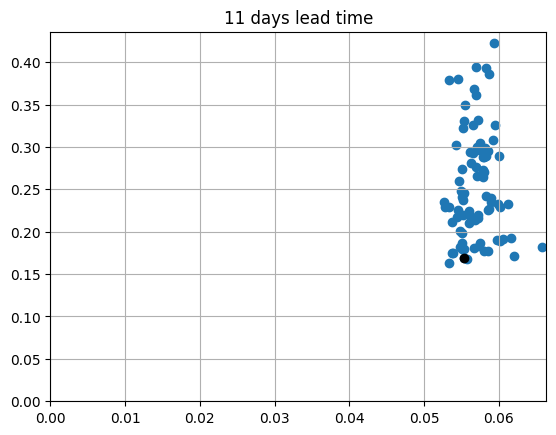

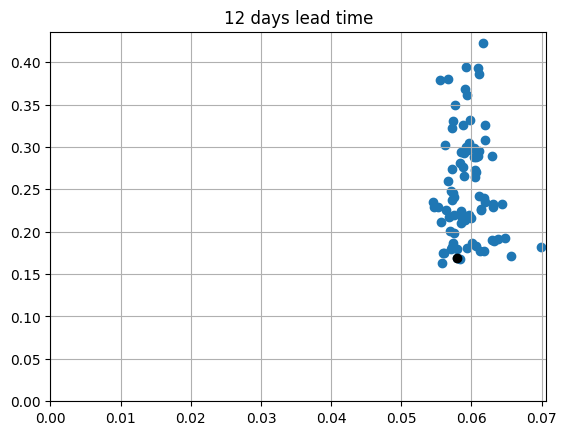

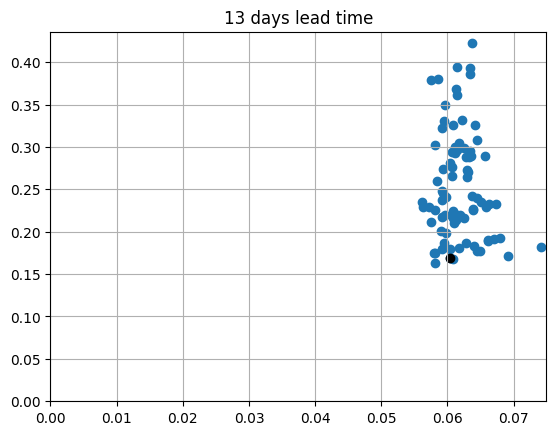

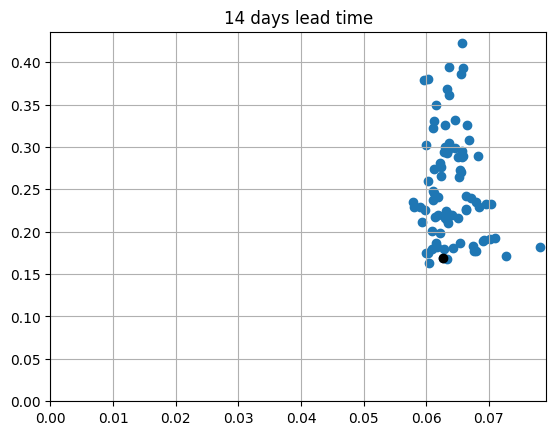

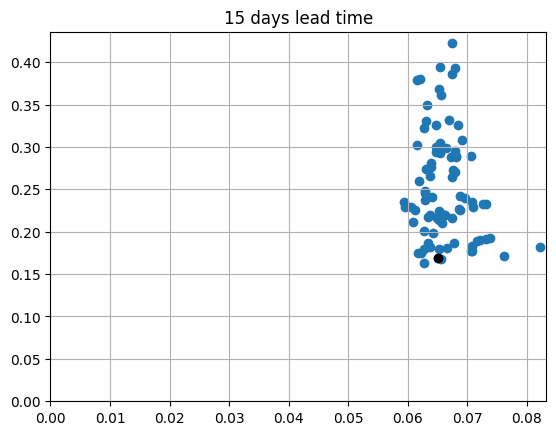

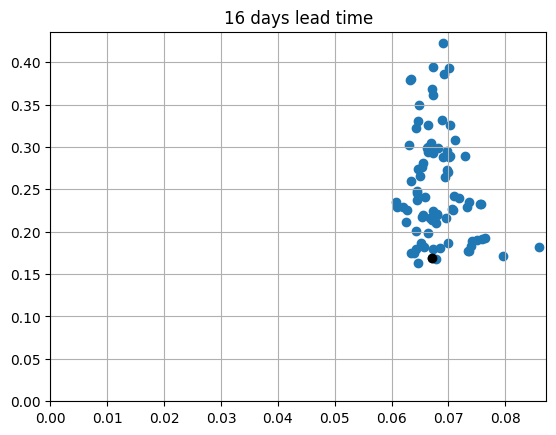

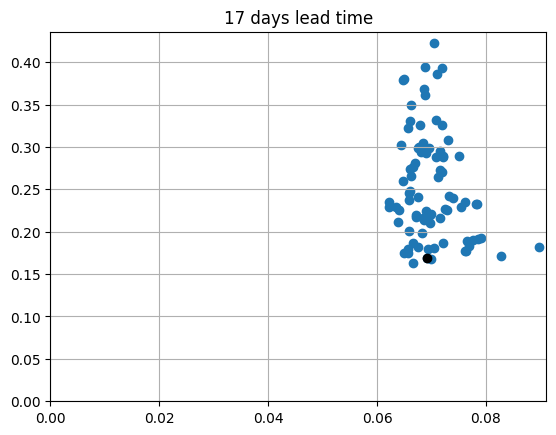

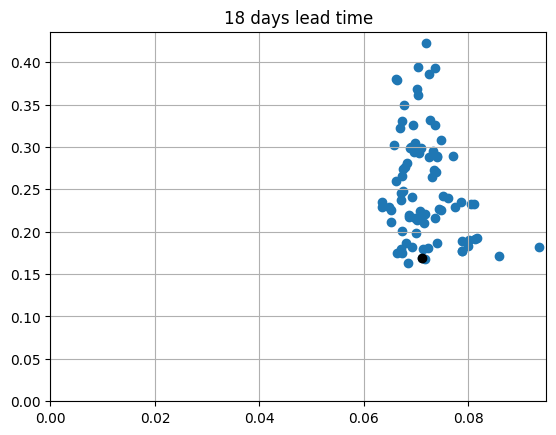

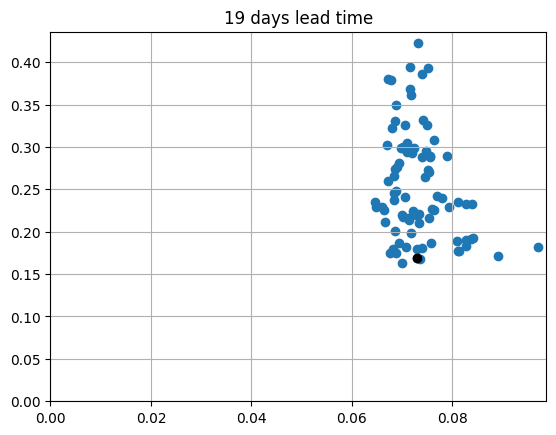

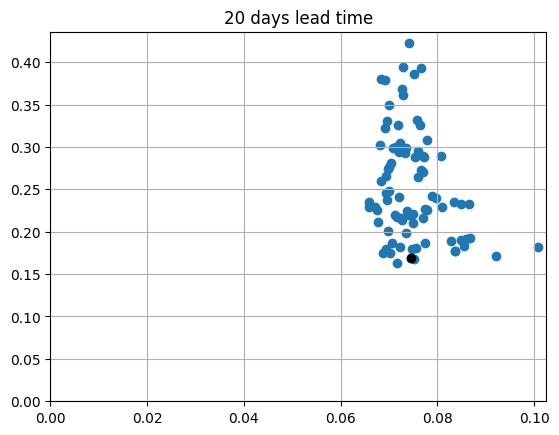

In [61]:
for days in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]:
    plt.figure()
    plt.scatter(RMSE_snapshot(days), RMSE_ssh_mean)
    plt.scatter(RMSE_snapshot(days)[8], RMSE_ssh_mean[8], color='k')
    plt.grid()
    plt.xlim([0,None])
    plt.ylim([0,None])
    plt.title(f'{days} days lead time')

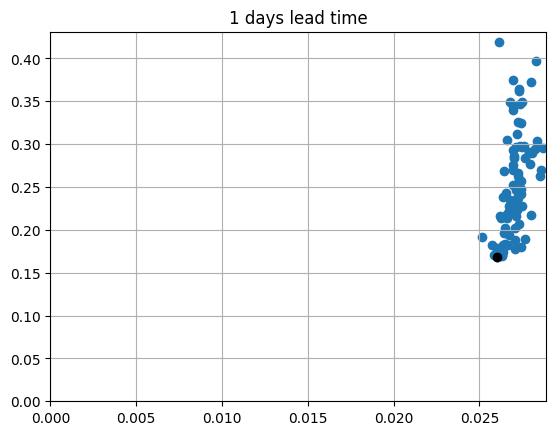

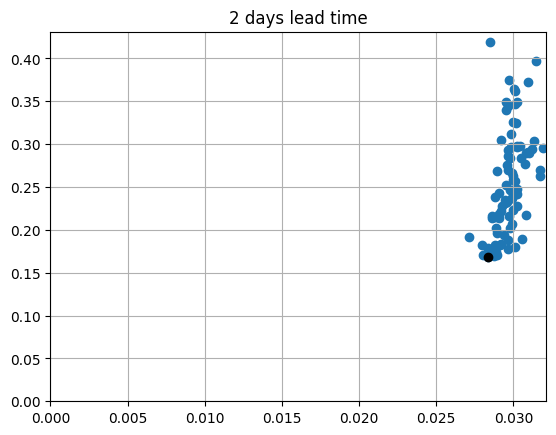

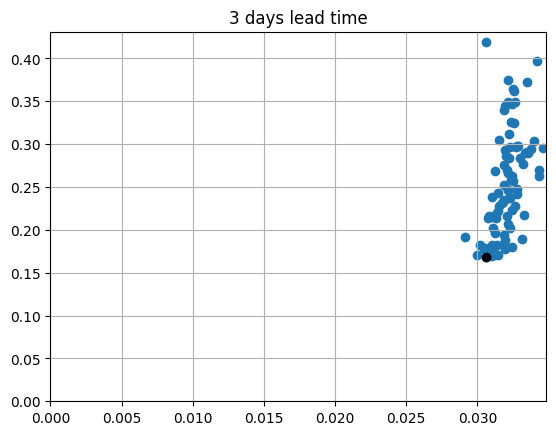

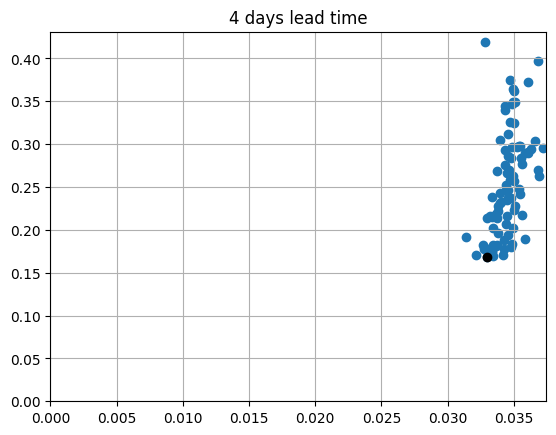

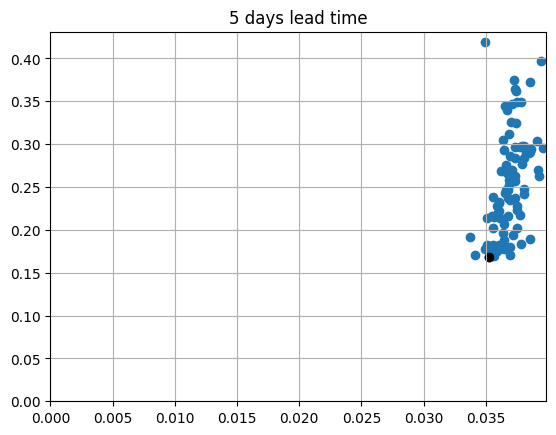

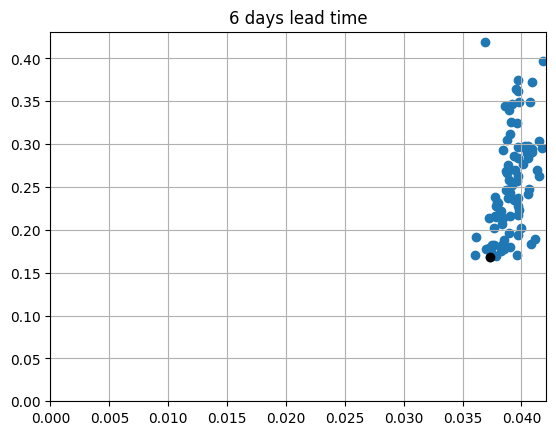

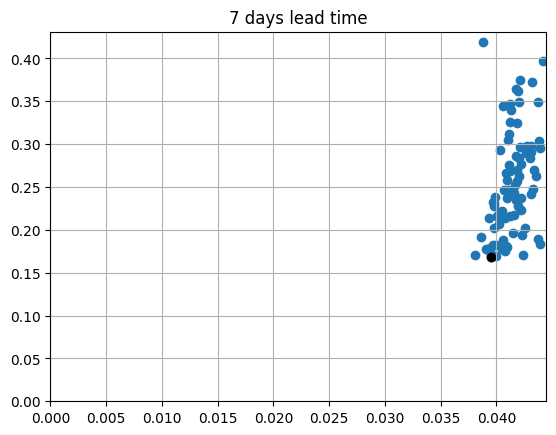

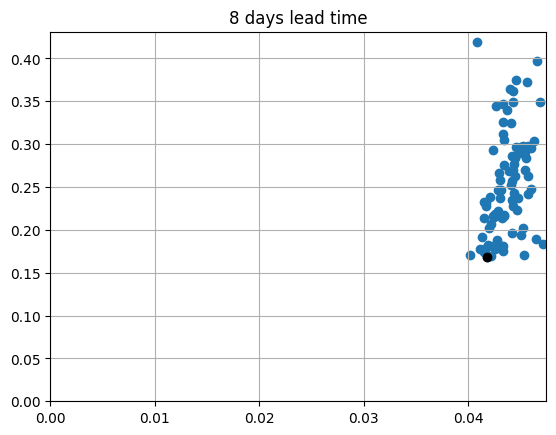

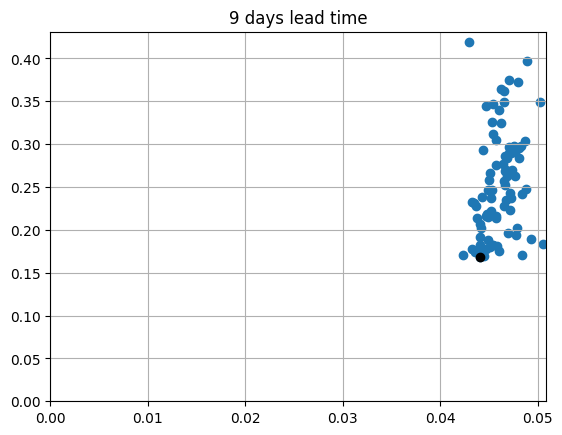

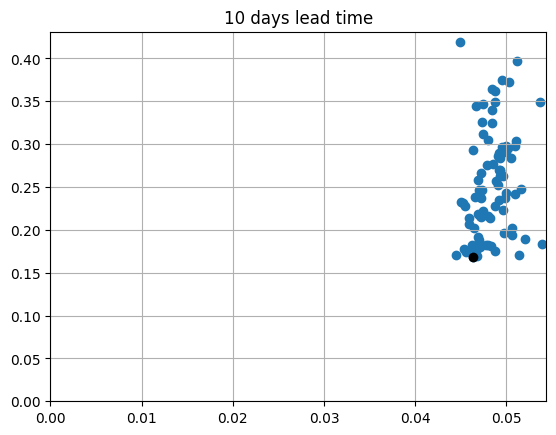

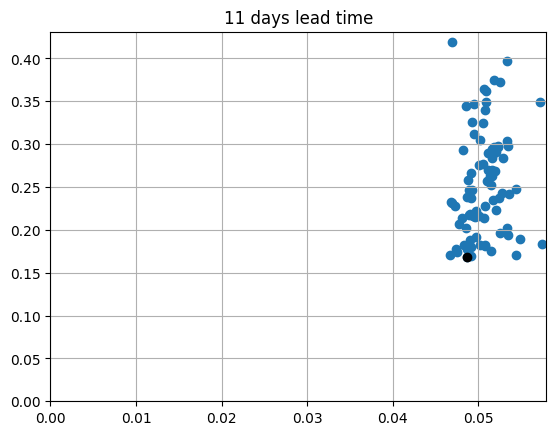

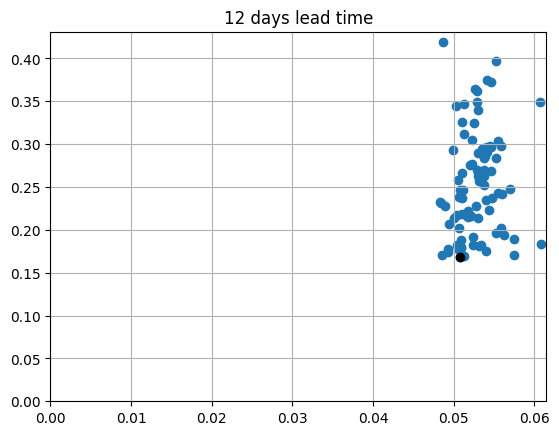

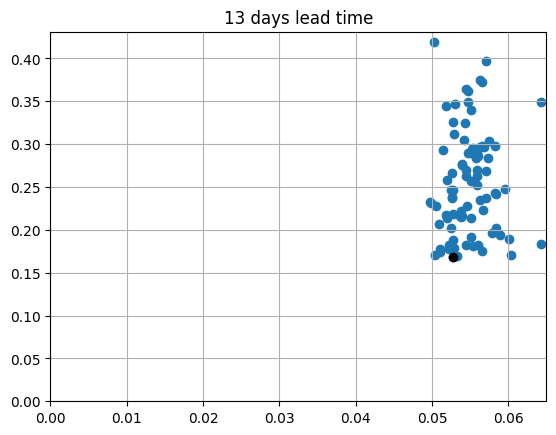

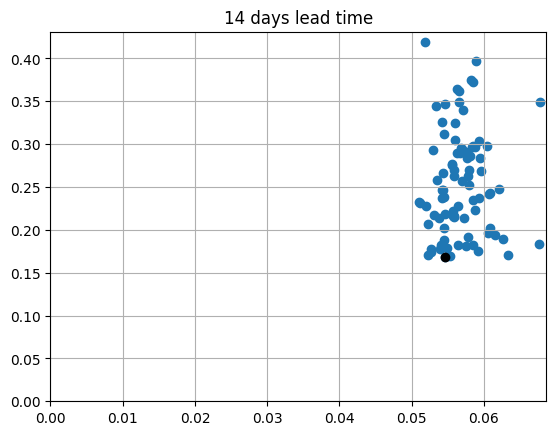

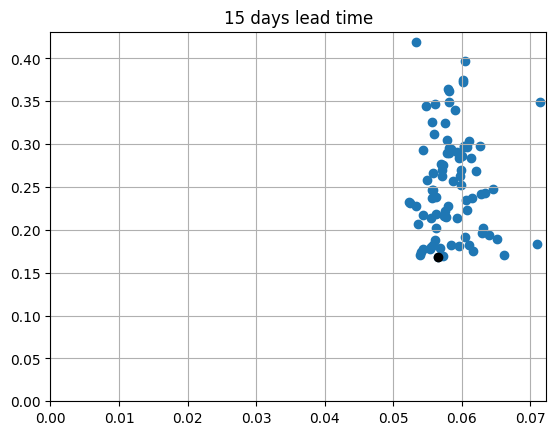

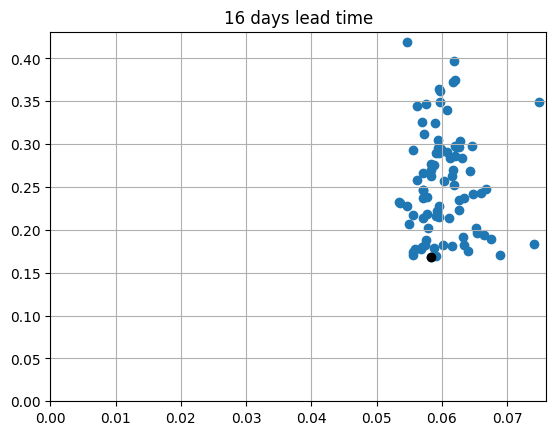

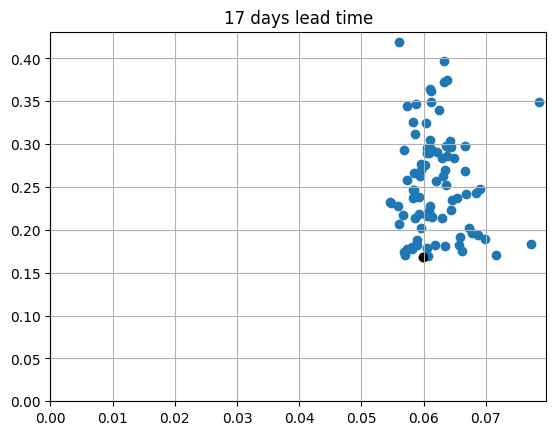

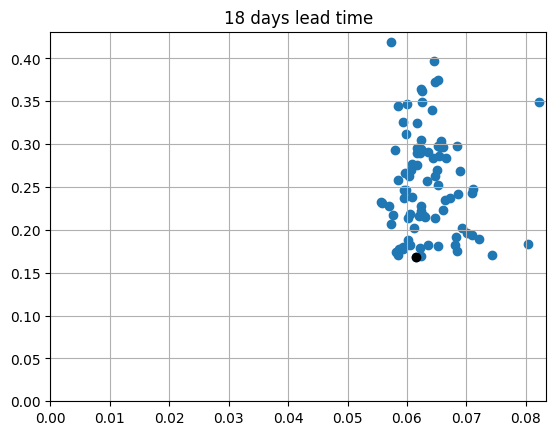

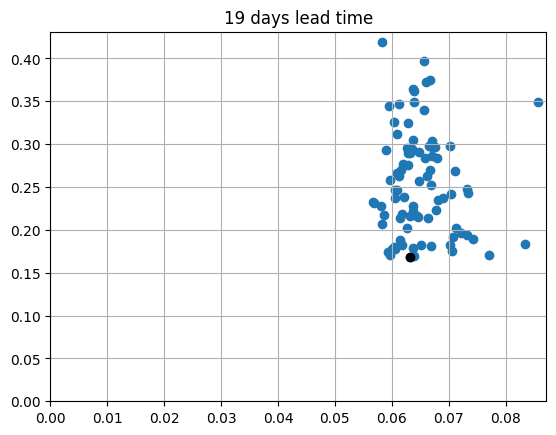

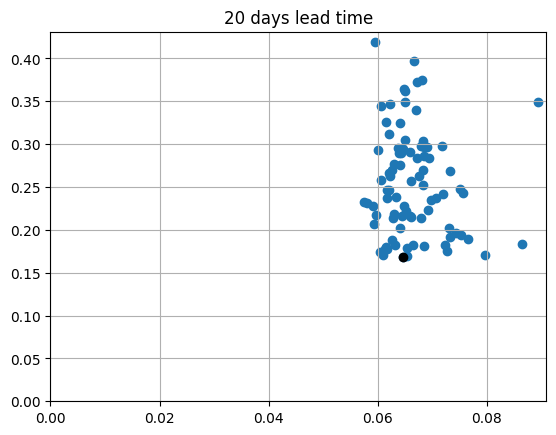

In [109]:
for days in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]:
    plt.figure()
    plt.scatter(RMSE_mean(days), RMSE_ssh_mean)
    plt.scatter(RMSE_mean(days)[8], RMSE_ssh_mean[8], color='k')
    plt.grid()
    plt.xlim([0,None])
    plt.ylim([0,None])
    plt.title(f'{days} days lead time')

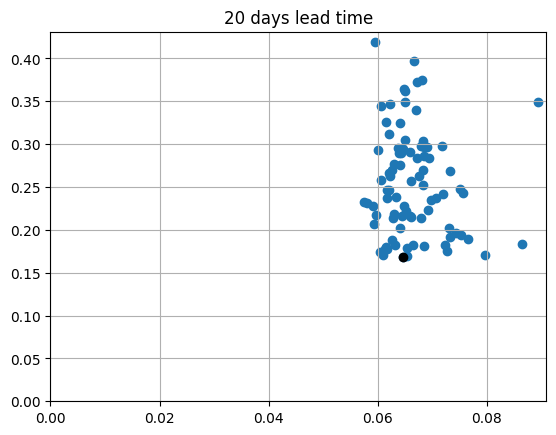

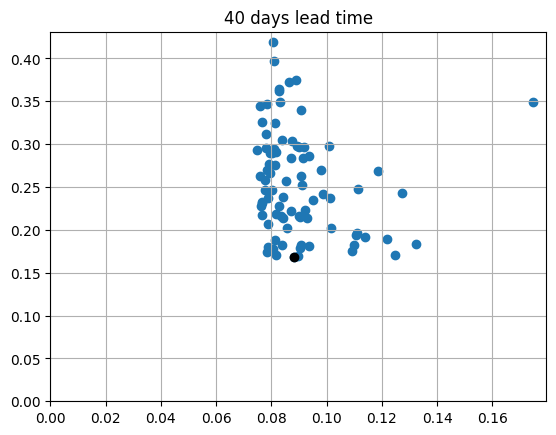

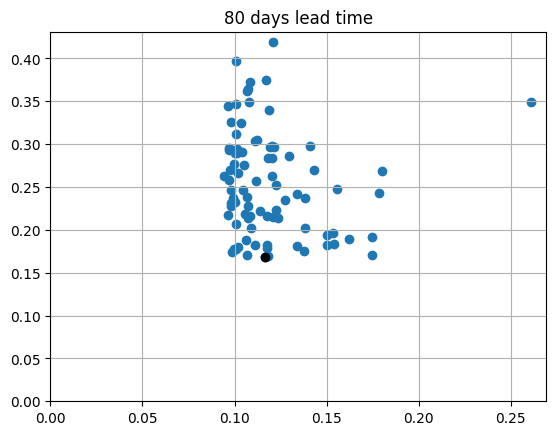

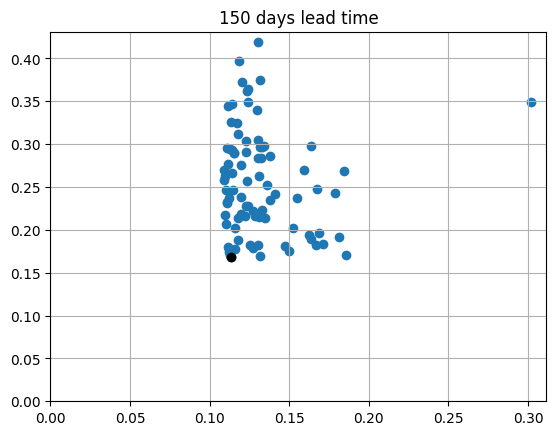

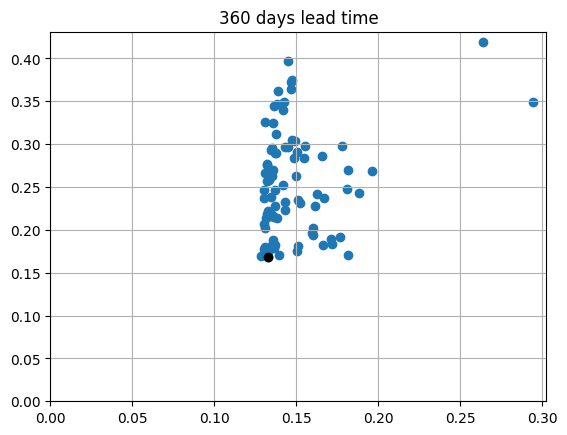

In [110]:
for days in [20, 40, 80, 150, 360]:
    plt.figure()
    plt.scatter(RMSE_mean(days), RMSE_ssh_mean)
    plt.scatter(RMSE_mean(days)[8], RMSE_ssh_mean[8], color='k')
    plt.grid()
    plt.xlim([0,None])
    plt.ylim([0,None])
    plt.title(f'{days} days lead time')

# Test nudging timescales

In [46]:
day1 = xr.open_dataset('/scratch/pp2681/mom6/CM26_Double_Gyre/nudging_scale/1day/output/prog__0001_002.nc', decode_times=False)
day1_repro = xr.open_dataset('/scratch/pp2681/mom6/CM26_Double_Gyre/nudging_scale/1day-reproducibility/output/prog__0001_002.nc', decode_times=False)
day10 = xr.open_dataset('/scratch/pp2681/mom6/CM26_Double_Gyre/nudging_scale/10days/output/prog__0001_002.nc', decode_times=False)

In [47]:
day1_ssh_nudging = day1.h_nudging.sum('zl')
day1_repro_ssh_nudging = day1_repro.h_nudging.sum('zl')
day10_ssh_nudging = day10.h_nudging.sum('zl')

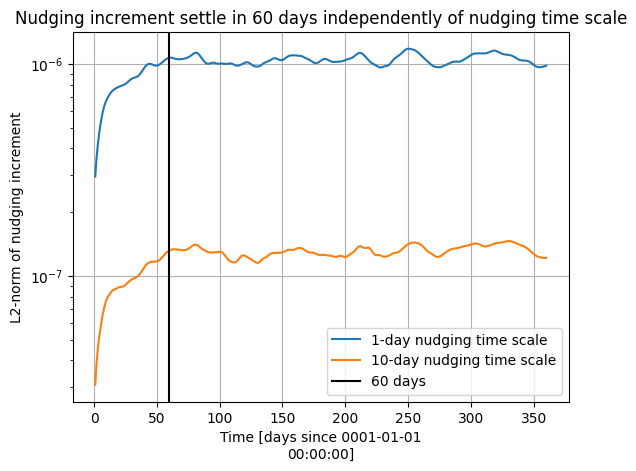

In [41]:
np.sqrt(((day1_ssh_nudging)**2).mean(['xh', 'yh'])).plot(label='1-day nudging time scale')
np.sqrt(((day10_ssh_nudging)**2).mean(['xh', 'yh'])).plot(label='10-day nudging time scale')

plt.yscale('log')
plt.ylabel('L2-norm of nudging increment')
plt.axvline(x=60, color='k', label='60 days')
plt.title('Nudging increment settle in 60 days independently of nudging time scale')
plt.grid()
plt.legend()

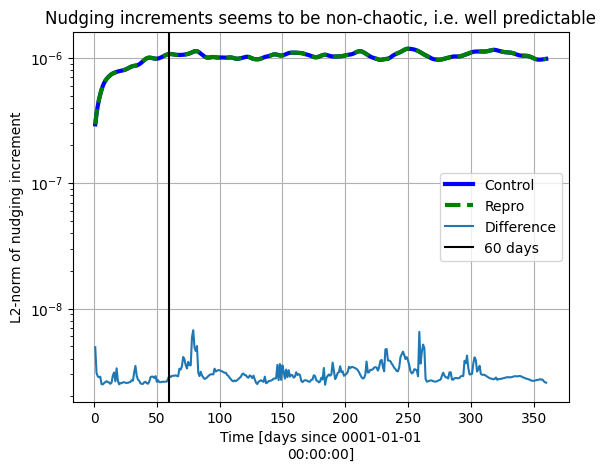

In [56]:
np.sqrt(((day1_ssh_nudging)**2).mean(['xh', 'yh'])).plot(label='Control', color='b', lw=3)
np.sqrt(((day1_repro_ssh_nudging)**2).mean(['xh', 'yh'])).plot(label='Repro', ls='--', color='g', lw=3)
np.sqrt(((day1_ssh_nudging - day1_repro_ssh_nudging)**2).mean(['xh', 'yh'])).plot(label='Difference')

plt.yscale('log')
plt.ylabel('L2-norm of nudging increment')
plt.axvline(x=60, color='k', label='60 days')
plt.title('Nudging increments seems to be non-chaotic, i.e. well predictable')
plt.grid()
plt.legend()

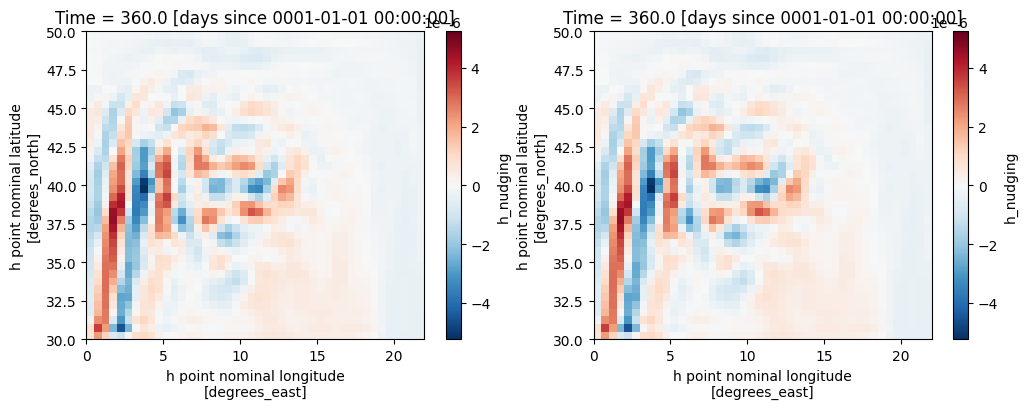

In [61]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
day1_ssh_nudging[-1].plot()

plt.subplot(1,2,2)
day1_repro_ssh_nudging[-1].plot()

# Statistical correlation between nudging increment and climate y100

In [ ]:
y20 = xr.open_dataset('/scratch/pp2681/mom6/CM26_Double_Gyre/calibration/20-years/R2_FGR3/y100.nc').isel(iter=0).isel(res=0)

In [4]:
# First metric
RMSE_ssh_mean = y20.RMSE_e_mean.isel(zi=0).values

In [5]:
# First metric
RMSE_ssh_std = y20.RMSE_e_std.isel(zi=0).values

In [12]:
nudging_ssh_ens = xr.DataArray(np.zeros((100, 360, 40, 44)) * np.nan, dims=['ens', 'Time', 'yh', 'xh'])
for ens_member in range(100):
    try:
        nudging_ssh_ens[ens_member] = xr.open_dataset(f'/scratch/pp2681/mom6/CM26_Double_Gyre/calibration/online_training/R2_FGR3_nudging_1day/iteration-00/R2/ens-member-{ens_member:02d}/output/prog__0001_002.nc').h_nudging.sum('zl')
    except:
        pass

In [11]:
nudging_10days_ssh_ens = xr.DataArray(np.zeros((100, 360, 40, 44)) * np.nan, dims=['ens', 'Time', 'yh', 'xh'])
for ens_member in range(100):
    try:
        nudging_10days_ssh_ens[ens_member] = xr.open_dataset(f'/scratch/pp2681/mom6/CM26_Double_Gyre/calibration/online_training/R2_FGR3_nudging_10day/iteration-00/R2/ens-member-{ens_member:02d}/output/prog__0001_002.nc').h_nudging.sum('zl')
    except:
        pass

In [17]:
nudging_increment_norm = np.sqrt(((nudging_ssh_ens)**2).mean(['xh', 'yh']))
nudging_10_days_increment_norm = np.sqrt(((nudging_10days_ssh_ens)**2).mean(['xh', 'yh']))

In [18]:
nudging_year_mean_norm = np.sqrt(((nudging_ssh_ens.mean('Time'))**2).mean(['xh', 'yh']))
nudging_10_days_year_mean_norm = np.sqrt(((nudging_10days_ssh_ens.mean('Time'))**2).mean(['xh', 'yh']))

Text(0, 0.5, 'RMSE of 10-year mean SSH')

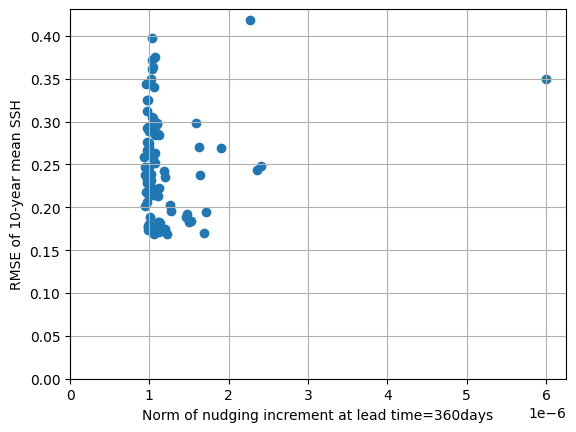

In [19]:
plt.scatter(nudging_increment_norm.isel(Time=359), RMSE_ssh_mean)
plt.grid()
plt.xlim([0,None])
plt.ylim([0,None])
plt.xlabel('Norm of nudging increment at lead time=360days')
plt.ylabel('RMSE of 10-year mean SSH')

Text(0, 0.5, 'RMSE of 10-year mean SSH')

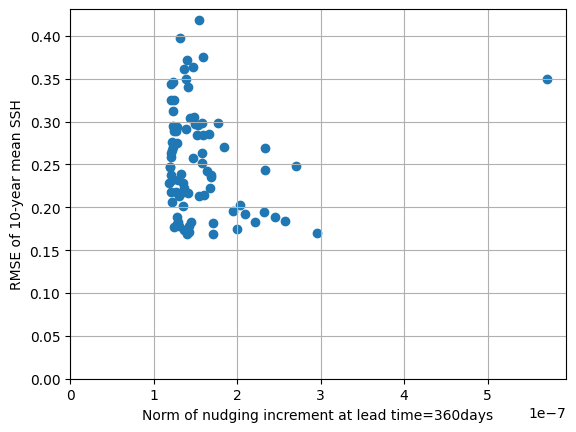

In [26]:
plt.scatter(nudging_10_days_increment_norm.isel(Time=359), RMSE_ssh_mean)
plt.grid()
plt.xlim([0,None])
plt.ylim([0,None])
plt.xlabel('Norm of nudging increment at lead time=360days')
plt.ylabel('RMSE of 10-year mean SSH')

Text(0, 0.5, 'RMSE of 10-year mean SSH')

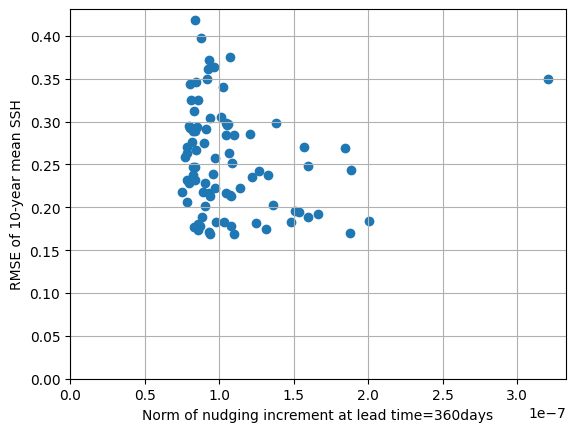

In [29]:
plt.scatter(nudging_10_days_year_mean_norm, RMSE_ssh_mean)
plt.grid()
plt.xlim([0,None])
plt.ylim([0,None])
plt.xlabel('Norm of nudging increment at lead time=360days')
plt.ylabel('RMSE of 10-year mean SSH')

Text(0, 0.5, 'RMSE of 10-year mean SSH')

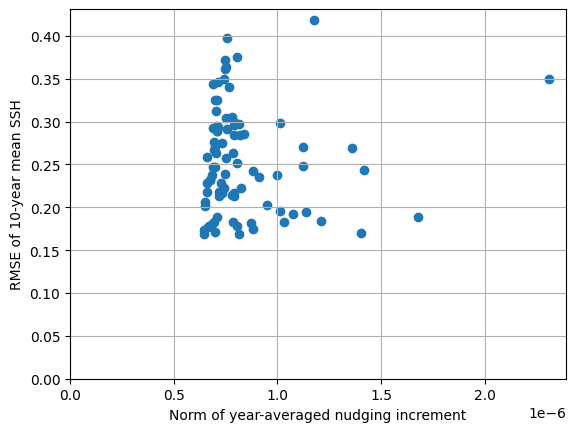

In [27]:
plt.scatter(nudging_year_mean_norm, RMSE_ssh_mean)
plt.grid()
plt.xlim([0,None])
plt.ylim([0,None])
plt.xlabel('Norm of year-averaged nudging increment')
plt.ylabel('RMSE of 10-year mean SSH')

Text(0, 0.5, 'RMSE of 10-year std SSH')

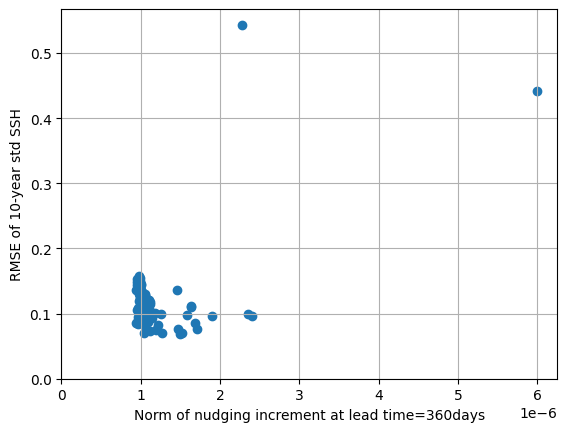

In [103]:
plt.scatter(nudging_increment_norm.isel(Time=359), RMSE_ssh_std)
plt.grid()
plt.xlim([0,None])
plt.ylim([0,None])
plt.xlabel('Norm of nudging increment at lead time=360days')
plt.ylabel('RMSE of 10-year std SSH')

Text(0, 0.5, 'RMSE of 10-year mean SSH')

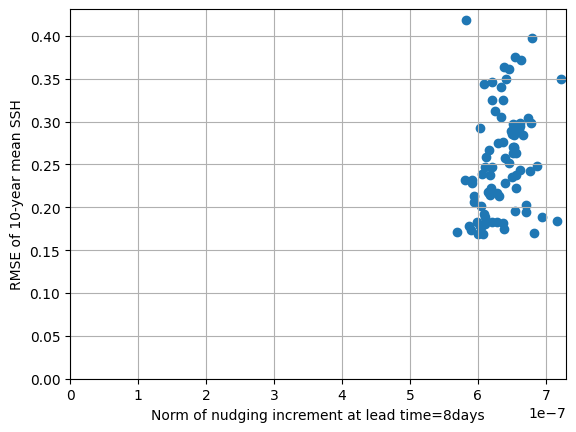

In [116]:
plt.scatter(nudging_increment_norm.isel(Time=7), RMSE_ssh_mean)
plt.grid()
plt.xlim([0,None])
plt.ylim([0,None])
plt.xlabel('Norm of nudging increment at lead time=8days')
plt.ylabel('RMSE of 10-year mean SSH')

Text(0.5, 1.0, 'The information which can be extracted from online learning \nis essentially the same as the information extracted from nudging increments')

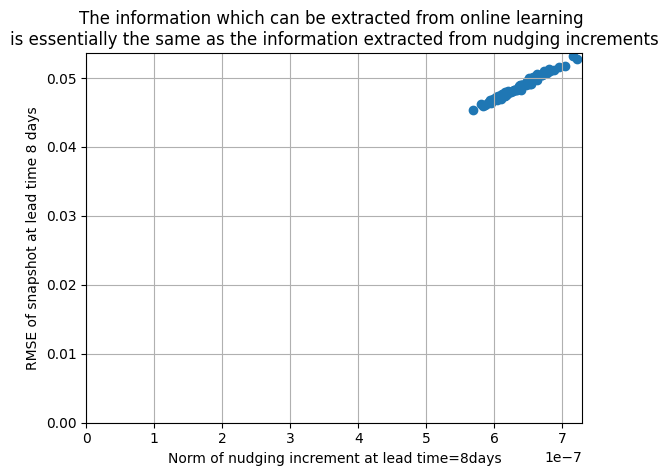

In [122]:
plt.scatter(nudging_increment_norm.isel(Time=7), RMSE_snapshot(day_max=8))
plt.grid()
plt.xlim([0,None])
plt.ylim([0,None])
plt.xlabel('Norm of nudging increment at lead time=8days')
plt.ylabel('RMSE of snapshot at lead time 8 days')
plt.title('The information which can be extracted from online learning \nis essentially the same as the information extracted from nudging increments')

# Nudging increments for GM

In [77]:
control_increment = xr.open_dataset(f'/scratch/pp2681/mom6/CM26_Double_Gyre/nudging_scale/1day/output/prog__0001_002.nc', decode_times=False).h_nudging.sum('zl')

In [78]:
GM_increment = xr.open_dataset(f'/scratch/pp2681/mom6/CM26_Double_Gyre/nudging_scale/1day-GM/output/prog__0001_002.nc', decode_times=False).h_nudging.sum('zl')

In [84]:
smag_increment = xr.open_dataset(f'/scratch/pp2681/mom6/CM26_Double_Gyre/nudging_scale/1day-smag/prog__0001_002.nc', decode_times=False).h_nudging.sum('zl')

In [85]:
control_increment_norm = np.sqrt((control_increment**2).mean(['xh', 'yh']))
GM_increment_norm = np.sqrt((GM_increment**2).mean(['xh', 'yh']))
smag_increment_norm = np.sqrt((smag_increment**2).mean(['xh', 'yh']))

Text(0.5, 1.0, 'Increasing smagorinsky reduces nudging increments')

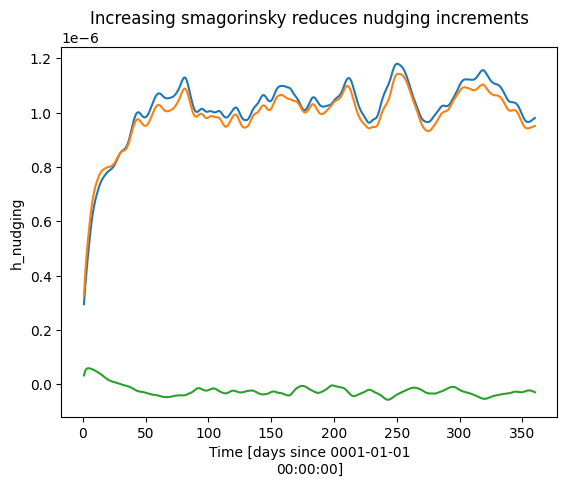

In [93]:
control_increment_norm.plot()
#GM_increment_norm.plot()
smag_increment_norm.plot()
#(GM_increment_norm-control_increment_norm).plot()
(smag_increment_norm-control_increment_norm).plot()
#plt.yscale('log')

plt.title('Increasing smagorinsky reduces nudging increments')

In [109]:
import sys
sys.path.append('../src-double-gyre')
from helpers.collection_of_experiments import CollectionOfExperiments

In [116]:
ds = CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Feb2022/bare', additional_subfolder='output')

In [117]:
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Feb2022/filtered', additional_subfolder='output')

/ext3/miniconda3/lib/python3.11/site-packages/xarray/plot/dataarray_plot.py:2140: UserWarning: linewidths is ignored by contourf
  primitive = ax.contourf(x, y, z, **kwargs)
/ext3/miniconda3/lib/python3.11/site-packages/xarray/plot/dataarray_plot.py:2140: UserWarning: linewidths is ignored by contourf
  primitive = ax.contourf(x, y, z, **kwargs)
/ext3/miniconda3/lib/python3.11/site-packages/xarray/plot/dataarray_plot.py:2140: UserWarning: linewidths is ignored by contourf
  primitive = ax.contourf(x, y, z, **kwargs)
/ext3/miniconda3/lib/python3.11/site-packages/xarray/plot/dataarray_plot.py:2140: UserWarning: linewidths is ignored by contourf
  primitive = ax.contourf(x, y, z, **kwargs)


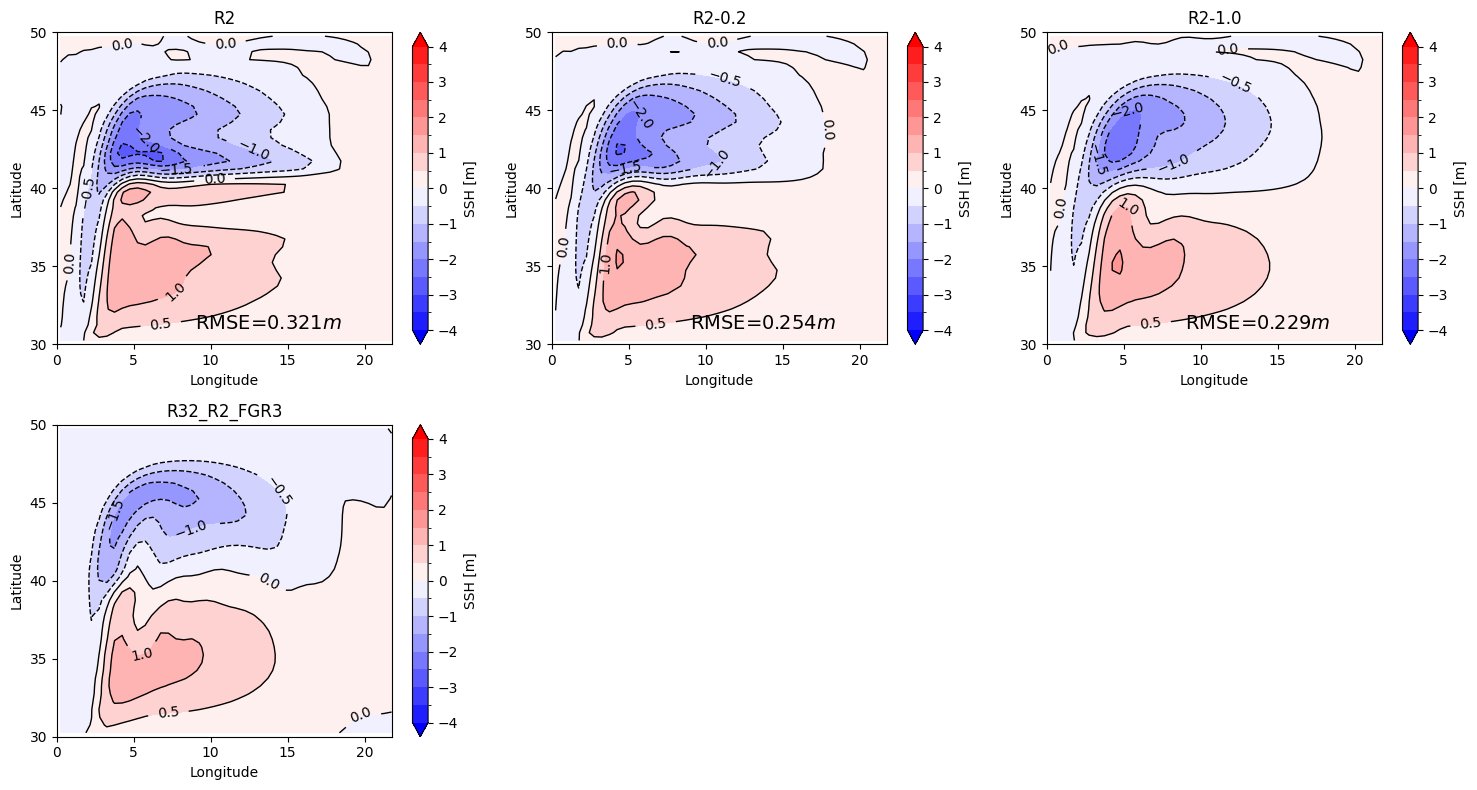

In [118]:
ds.plot_ssh(['R2', 'R2-0.2', 'R2-1.0', 'R32_R2_FGR3']);

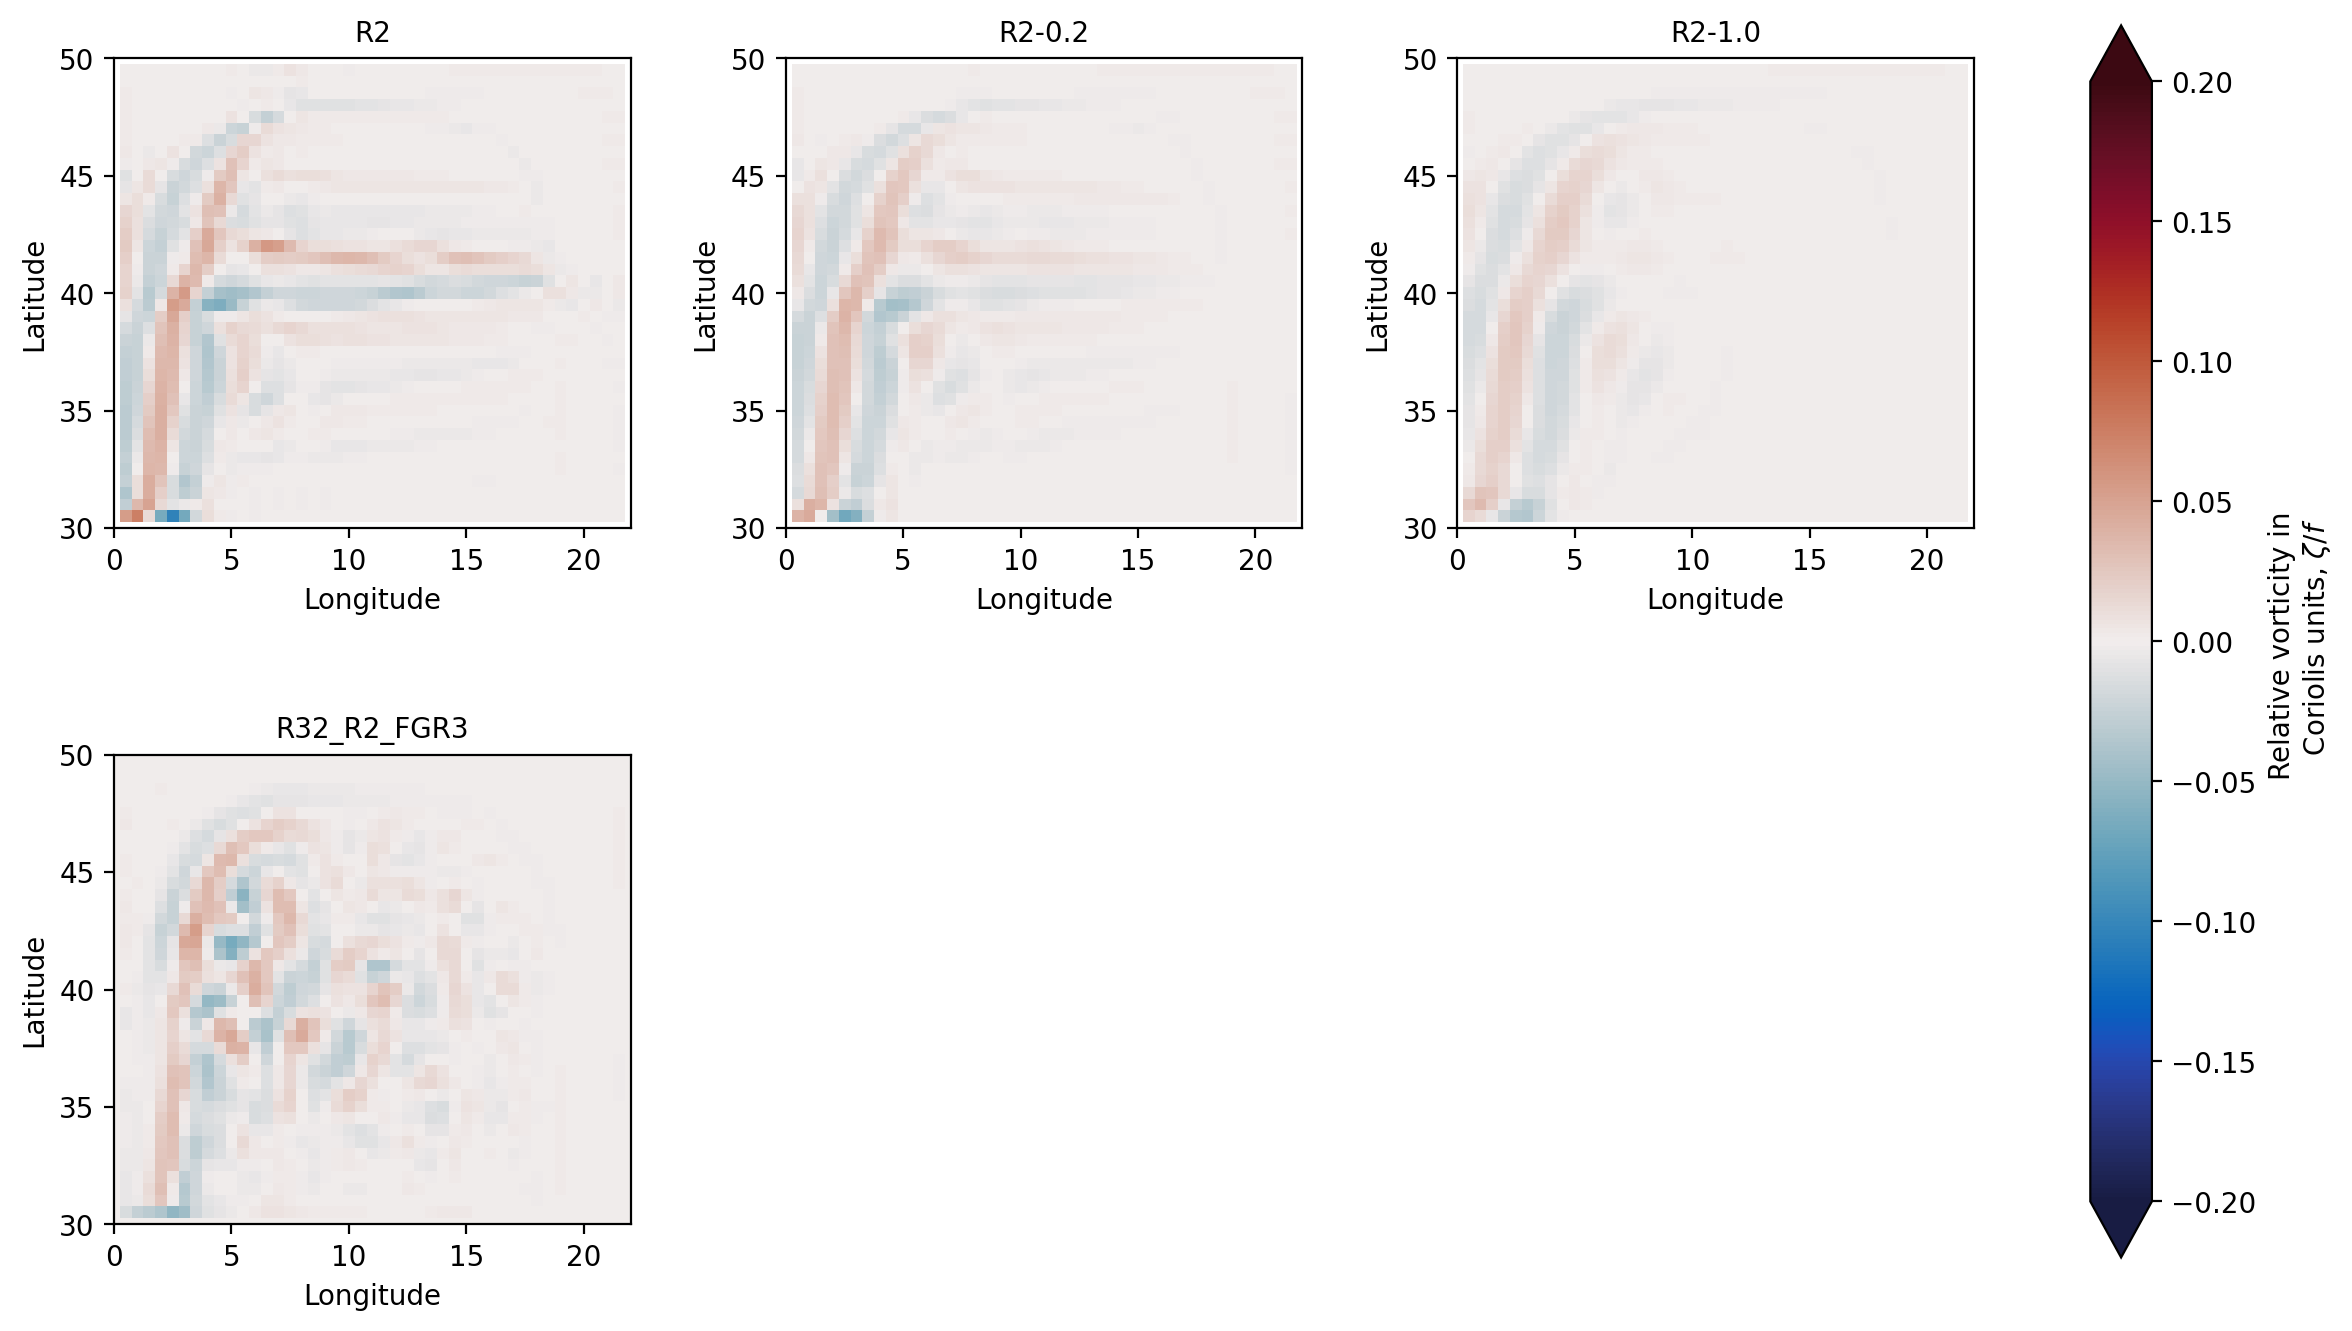

In [119]:
ds.plot_RV(['R2', 'R2-0.2', 'R2-1.0', 'R32_R2_FGR3']);

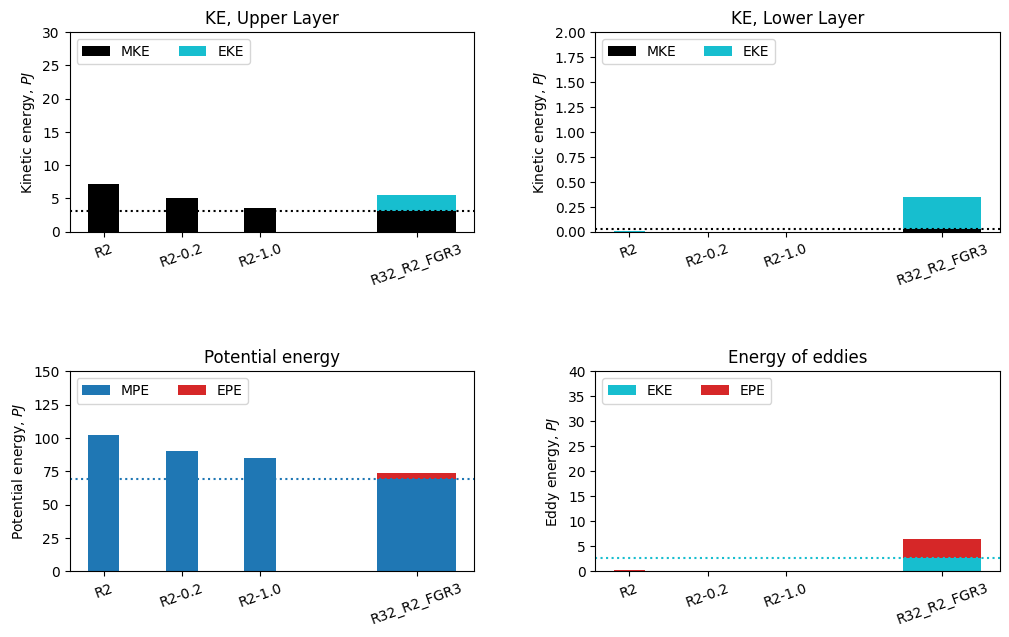

In [120]:
ds.plot_KE_PE(['R2', 'R2-0.2', 'R2-1.0', 'R32_R2_FGR3']);

# Long-time metrics

In [78]:
y100 = xr.open_dataset('/scratch/pp2681/mom6/CM26_Double_Gyre/calibration/hundred-years/R2_FGR3_series/metrics.nc').isel(res=0)
y20 = xr.open_dataset('/scratch/pp2681/mom6/CM26_Double_Gyre/calibration/20-years/R2_FGR3_series/metrics.nc').isel(res=0)
observation = xr.open_dataset('/home/pp2681/calibration/scripts/R32/R2_FGR3_series_loss.nc').astype('float64')

(0.0, 100.0)

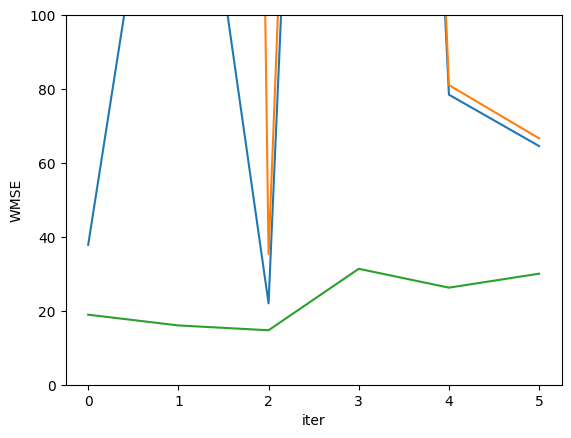

In [41]:
y100.WMSE_MAP.plot()
y100.WMSE.mean('ens').plot()
y100.WMSE.min('ens').plot()
#plt.yscale('log')
plt.ylim([0,100])

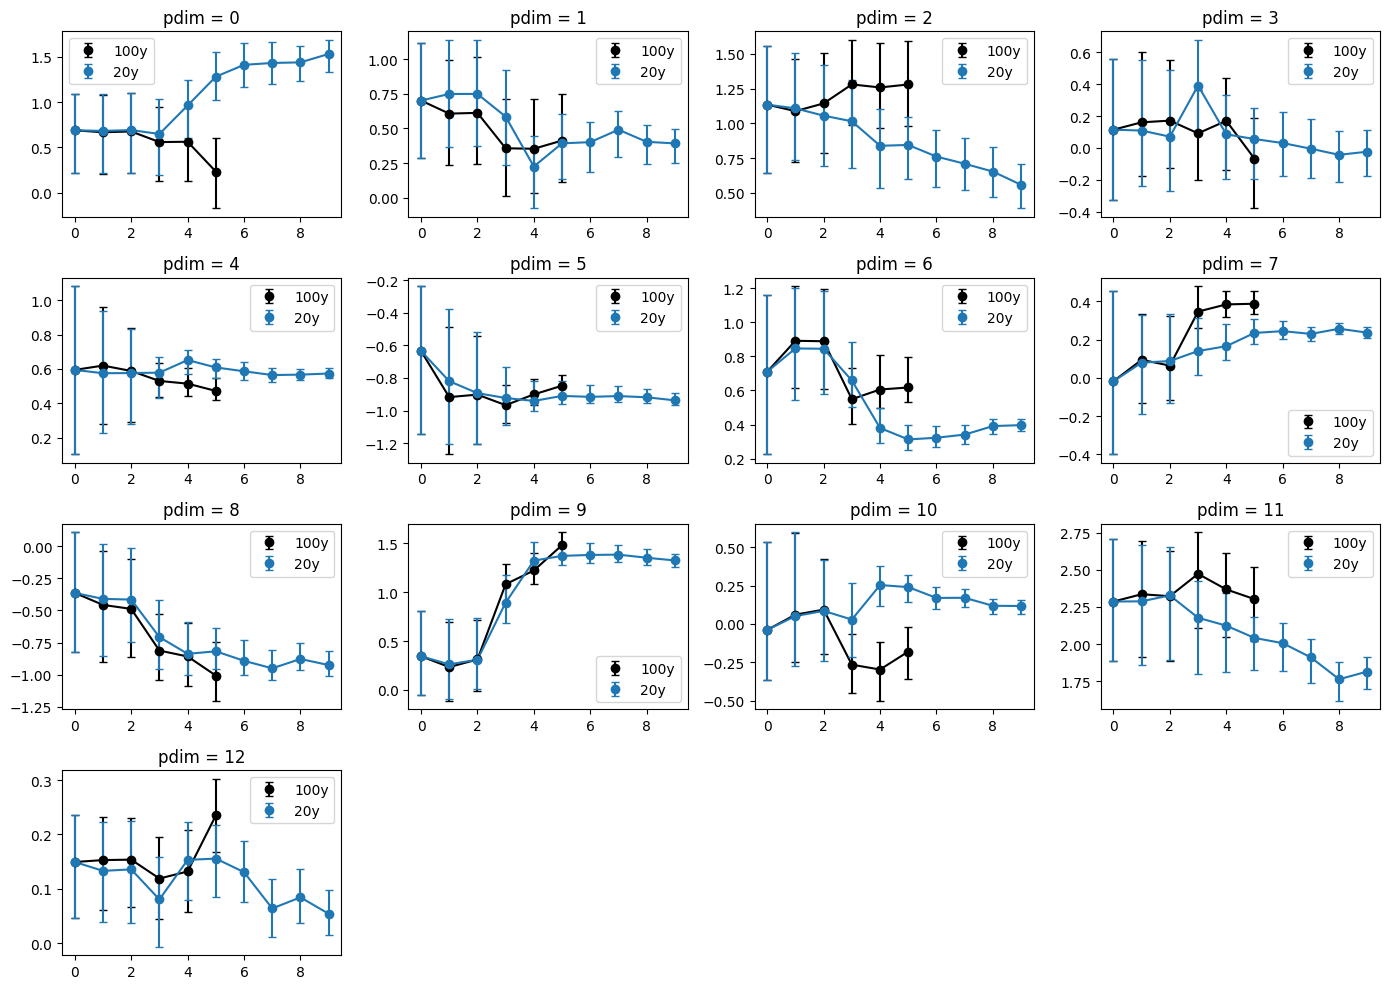

In [44]:
plt.figure(figsize=(14, 10))

for pdim in range(13):
    ax = plt.subplot(4, 4, pdim + 1)

    y = y100.param.isel(pdim=pdim)

    y_mean = y.mean('ens')
    y_min  = y.min('ens')
    y_max  = y.max('ens')

    x = np.arange(y_mean.size)

    ax.plot(x, y_mean.values, color='k')
    ax.errorbar(
        x,
        y_mean.values,
        yerr=[y_mean.values - y_min.values,
              y_max.values - y_mean.values],
        fmt='o',
        capsize=3, color='k',
        label='100y'
    )

    y = y20.param.isel(pdim=pdim)

    y_mean = y.mean('ens')
    y_min  = y.min('ens')
    y_max  = y.max('ens')

    x = np.arange(y_mean.size)

    ax.plot(x, y_mean.values, color='tab:blue')
    ax.errorbar(
        x,
        y_mean.values,
        yerr=[y_mean.values - y_min.values,
              y_max.values - y_mean.values],
        fmt='o',
        capsize=3, color='tab:blue',
        label='20y'
    )

    ax.set_title(f"pdim = {pdim}")
    ax.legend()

plt.tight_layout()

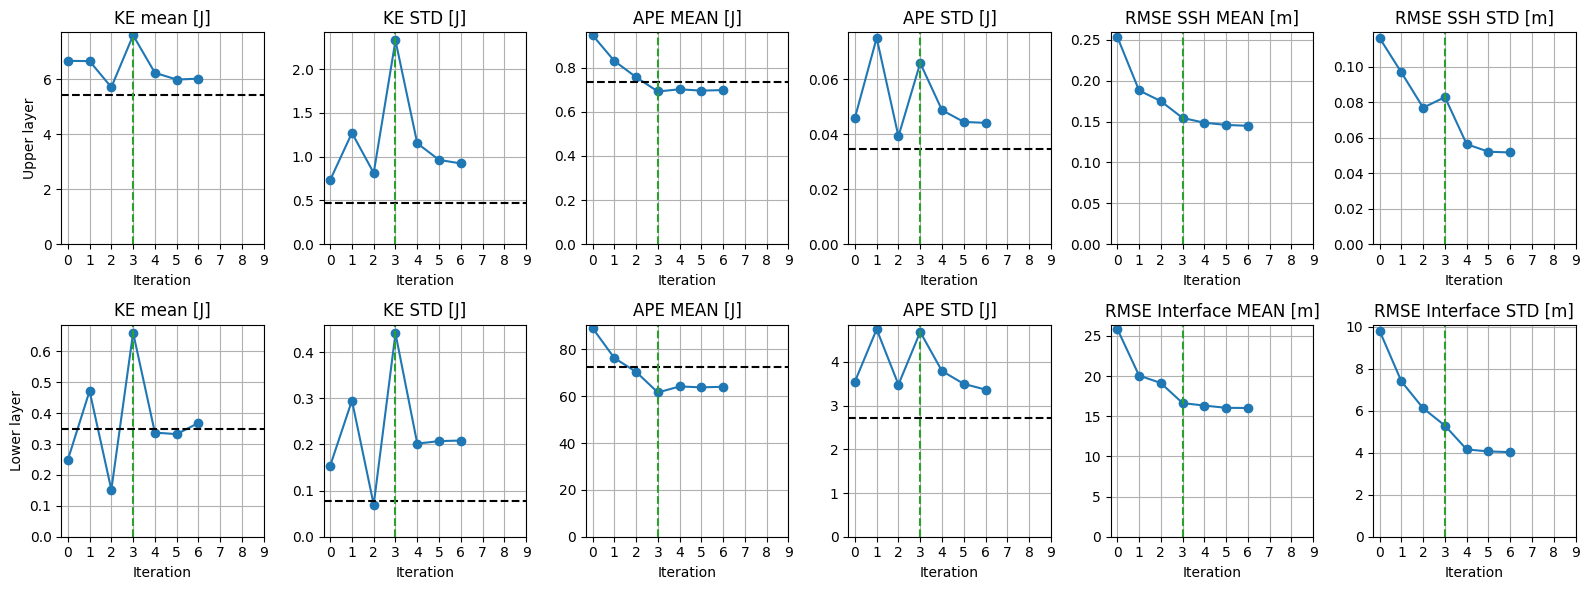

In [79]:
plt.figure(figsize=(16,6))


plt.subplot(2,6,1)
y100.KE_mean.isel(zl=0).mean('ens').plot(marker='o')
plt.axhline(y=observation.KE_mean.isel(zl=0), color='k', ls='--')
plt.ylim([0,None])
plt.xticks(np.arange(10))
plt.grid()
plt.xlabel('Iteration')
plt.title('KE mean [J]')
plt.ylabel('Upper layer')


plt.subplot(2,6,2)
y100.KE_std.isel(zl=0).mean('ens').plot(marker='o')
plt.axhline(y=observation.KE_std.isel(zl=0), color='k', ls='--')
plt.title('')
plt.ylim([0,None])
plt.xticks(np.arange(10))
plt.grid()
plt.xlabel('Iteration')
plt.title('KE STD [J]')
plt.ylabel('')

plt.subplot(2,6,3)
y100.APE_mean.isel(zi=0).mean('ens').plot(marker='o')
plt.axhline(y=observation.APE_mean.isel(zi=0), color='k', ls='--')
plt.title('')
plt.ylim([0,None])
plt.xticks(np.arange(10))
plt.grid()
plt.xlabel('Iteration')
plt.title('APE MEAN [J]')
plt.ylabel('')

plt.subplot(2,6,4)
y100.APE_std.isel(zi=0).mean('ens').plot(marker='o')
plt.axhline(y=observation.APE_std.isel(zi=0), color='k', ls='--')
plt.title('')
plt.ylim([0,None])
plt.xticks(np.arange(10))
plt.grid()
plt.xlabel('Iteration')
plt.title('APE STD [J]')
plt.ylabel('')

plt.subplot(2,6,5)
y100.RMSE_e_mean.isel(zi=0).mean('ens').plot(marker='o')
plt.title('')
plt.ylim([0,None])
plt.xticks(np.arange(10))
plt.grid()
plt.xlabel('Iteration')
plt.title('RMSE SSH MEAN [m]')
plt.ylabel('')

plt.subplot(2,6,6)
y100.RMSE_e_std.isel(zi=0).mean('ens').plot(marker='o')
plt.title('')
plt.ylim([0,None])
plt.xticks(np.arange(10))
plt.grid()
plt.xlabel('Iteration')
plt.title('RMSE SSH STD [m]')
plt.ylabel('')

plt.subplot(2,6,7)
y100.KE_mean.isel(zl=1).mean('ens').plot(marker='o')
plt.axhline(y=observation.KE_mean.isel(zl=1), color='k', ls='--')
plt.ylim([0,None])
plt.xticks(np.arange(10))
plt.grid()
plt.xlabel('Iteration')
plt.title('KE mean [J]')
plt.ylabel('Lower layer')


plt.subplot(2,6,8)
y100.KE_std.isel(zl=1).mean('ens').plot(marker='o')
plt.axhline(y=observation.KE_std.isel(zl=1), color='k', ls='--')
plt.title('')
plt.ylim([0,None])
plt.xticks(np.arange(10))
plt.grid()
plt.xlabel('Iteration')
plt.title('KE STD [J]')
plt.ylabel('')

plt.subplot(2,6,9)
y100.APE_mean.isel(zi=1).mean('ens').plot(marker='o')
plt.axhline(y=observation.APE_mean.isel(zi=1), color='k', ls='--')
plt.title('')
plt.ylim([0,None])
plt.xticks(np.arange(10))
plt.grid()
plt.xlabel('Iteration')
plt.title('APE MEAN [J]')
plt.ylabel('')

plt.subplot(2,6,10)
y100.APE_std.isel(zi=1).mean('ens').plot(marker='o')
plt.axhline(y=observation.APE_std.isel(zi=1), color='k', ls='--')
plt.title('')
plt.ylim([0,None])
plt.xticks(np.arange(10))
plt.grid()
plt.xlabel('Iteration')
plt.title('APE STD [J]')
plt.ylabel('')

plt.subplot(2,6,11)
y100.RMSE_e_mean.isel(zi=1).mean('ens').plot(marker='o')
plt.title('')
plt.ylim([0,None])
plt.xticks(np.arange(10))
plt.grid()
plt.xlabel('Iteration')
plt.title('RMSE Interface MEAN [m]')
plt.ylabel('')

plt.subplot(2,6,12)
y100.RMSE_e_std.isel(zi=1).mean('ens').plot(marker='o')
plt.title('')
plt.ylim([0,None])
plt.xticks(np.arange(10))
plt.grid()
plt.xlabel('Iteration')
plt.title('RMSE Interface STD [m]')
plt.ylabel('')


for j in range(1,13):
    plt.subplot(2,6,j)
    plt.axvline(x=3, ls='--', color='tab:green')

plt.tight_layout()



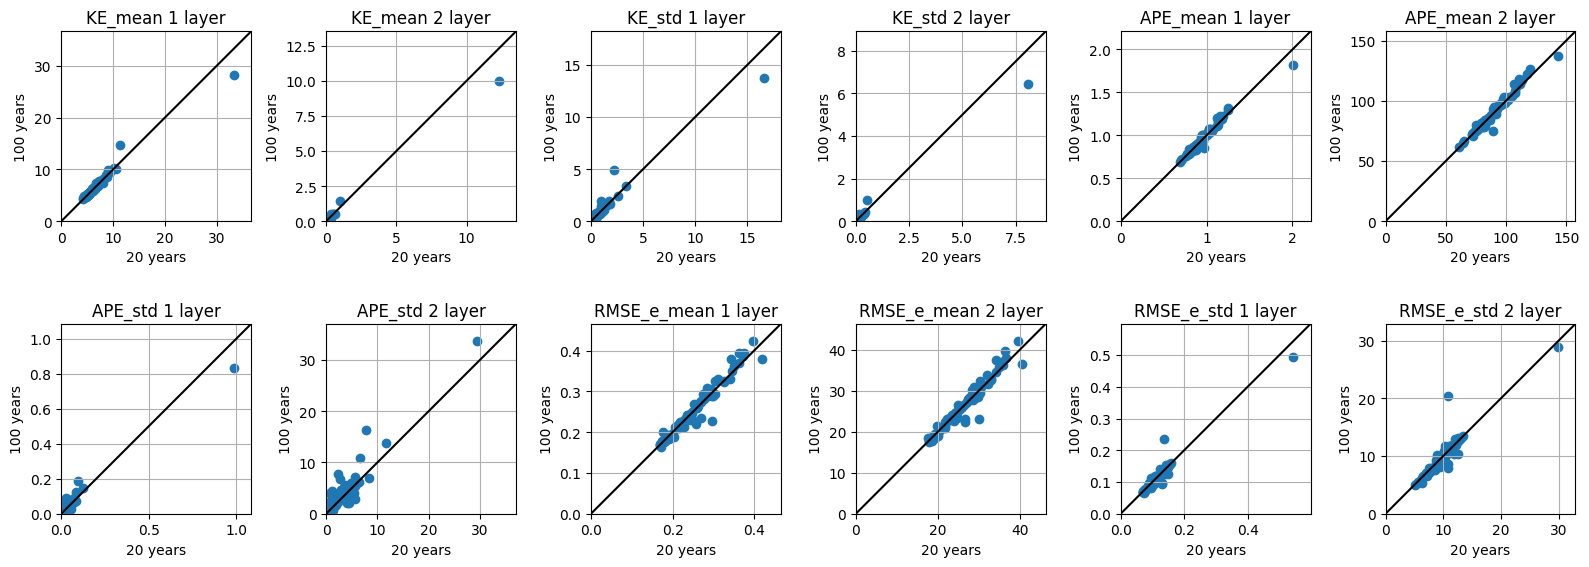

In [58]:
plt.figure(figsize=(16,6))
j = 0
for v in ['KE_mean', 'KE_std', 'APE_mean', 'APE_std', 'RMSE_e_mean', 'RMSE_e_std']:
    for lay in range(2):
        j += 1
        plt.subplot(2,6,j)
        x = y20.isel(iter=0)[v][:,lay]
        y = y100.isel(iter=0)[v][:,lay]
        plt.scatter(x,y)
        plt.grid()
        xmin = 0
        xmax = 1.1*np.maximum(x,y).max()
        plt.gca().set_aspect(1)
        plt.plot([0,xmax], [0,xmax], color='k')
        plt.xlim([xmin, xmax])
        plt.ylim([xmin, xmax])
        plt.xlabel('20 years')
        plt.ylabel('100 years')
        plt.title(v+f' {lay+1} layer')

plt.tight_layout()

# Can we scale energy STD and mean similarly? Is error in STD is comparable to error in mean?

In [73]:
def rms(x):
    return float(np.sqrt((x**2).mean()))

Text(0.5, 1.0, 'KE mean scale: 3.096137124249385\n KE std scale: 1.6392015417223347')

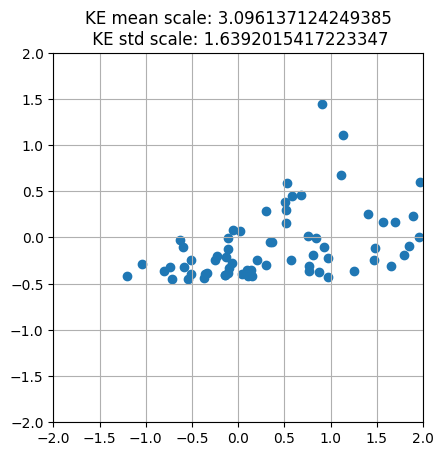

In [74]:
x = (y100.isel(iter=0).KE_mean.isel(zl=0) - observation.KE_mean.isel(zl=0))
y = (y100.isel(iter=0).KE_std.isel(zl=0) - observation.KE_std.isel(zl=0))
plt.scatter(x, y)
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.gca().set_aspect(1.)
plt.grid()
plt.title(f'KE mean scale: {rms(x)}\n KE std scale: {rms(y)}')

Text(0.5, 1.0, 'KE mean scale: 1.0871106925952634\n KE std scale: 0.7079660814135338')

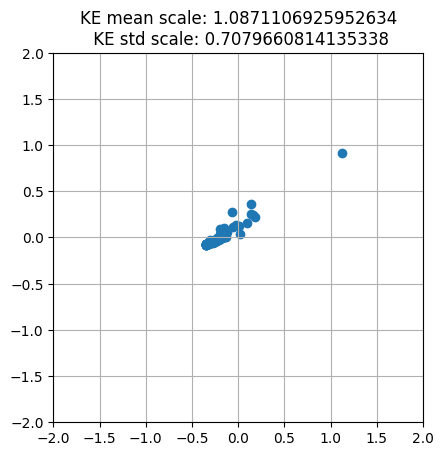

In [75]:
x = (y100.isel(iter=0).KE_mean.isel(zl=1) - observation.KE_mean.isel(zl=1))
y = (y100.isel(iter=0).KE_std.isel(zl=1) - observation.KE_std.isel(zl=1))
plt.scatter(x, y)
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.gca().set_aspect(1.)
plt.grid()
plt.title(f'KE mean scale: {rms(x)}\n KE std scale: {rms(y)}')

Text(0.5, 1.0, 'APE mean scale: 0.2693578721822232\n APE std scale: 0.09290033472643155')

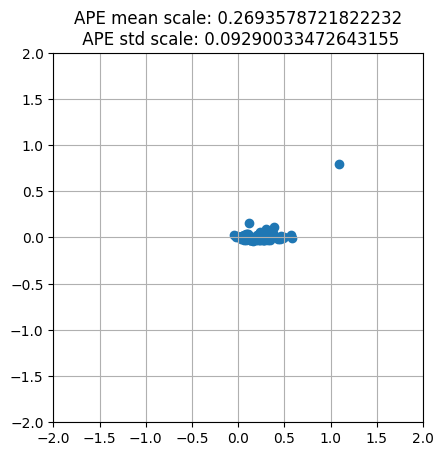

In [77]:
x = (y100.isel(iter=0).APE_mean.isel(zi=0) - observation.APE_mean.isel(zi=0))
y = (y100.isel(iter=0).APE_std.isel(zi=0) - observation.APE_std.isel(zi=0))
plt.scatter(x, y)
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.gca().set_aspect(1.)
plt.grid()
plt.title(f'APE mean scale: {rms(x)}\n APE std scale: {rms(y)}')

Text(0.5, 1.0, 'APE mean scale: 21.85220625389054\n APE std scale: 4.41443262909676')

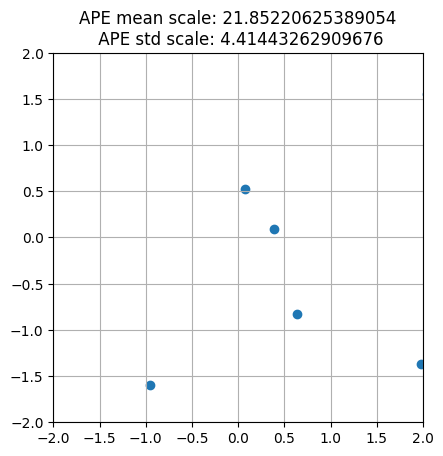

In [80]:
x = (y100.isel(iter=0).APE_mean.isel(zi=1) - observation.APE_mean.isel(zi=1))
y = (y100.isel(iter=0).APE_std.isel(zi=1) - observation.APE_std.isel(zi=1))
plt.scatter(x, y)
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.gca().set_aspect(1.)
plt.grid()
plt.title(f'APE mean scale: {rms(x)}\n APE std scale: {rms(y)}')